In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [2]:
# Libraries
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import csv
import numpy as np
import random
import matplotlib.pyplot as plt

In [3]:
# Open CSV files.

full_tweets_labels = []
train_tweets = []
train_labels = []
test_tweets = []

with open('/kaggle/input/nlp-getting-started/train.csv', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        #print(row)
        full_tweets_labels.append(row[-2:])
        #train_tweets.append(row[-2])
        #train_labels.append(row[-1])
        
random.seed(1)
random.shuffle(full_tweets_labels)

for row in full_tweets_labels:
    train_tweets.append(row[0])
    train_labels.append(row[1])
        
with open('/kaggle/input/nlp-getting-started/test.csv', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        #print(row)
        test_tweets.append(row[-1])
        

print('Train tweets example: ', train_tweets[:5])
print('*'*30)
print('Train labels examples: ', train_labels[:5])
print('-'*30)
print('Test tweets example: ', test_tweets[:5])



Train tweets example:  ['Ignition Knock (Detonation) Sensor-Senso Standard fits 02-06 Acura RSX 2.0L-L4 http://t.co/VZaIQAMDCp http://t.co/ycecN44c8P', '#KAMINDOZ #reuters Debris confirmed from MH370; relatives hope for discovery of crash s... http://t.co/xrdwR8CDvM http://t.co/fxtfFL4aXy', 'There are people who plotted against me that are still wondering how I survived', '@crobscarla your lifetime odds of dying from an airplane accident are 1 in 8015.', 'This sale and demolition trend near Metrotown is sure resulting in some poorly maintained apartments. #burnaby #changefortheworse']
******************************
Train labels examples:  ['0', '1', '0', '0', '0']
------------------------------
Test tweets example:  ['Just happened a terrible car crash', 'Heard about #earthquake is different cities, stay safe everyone.', 'there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all', 'Apocalypse lighting. #Spokane #wildfires', 'Typhoon Soudelor kills

In [4]:
# Train-Val split.

grenze = int(len(train_tweets)*0.9)

val_tweets = train_tweets[grenze:]
val_labels = train_labels[grenze:]

train_tweets = train_tweets[:grenze]
train_labels = train_labels[:grenze]


In [5]:
# Tokenization process.
num_words = 10000  # I forgot tweets can have variable lengths, despite having a very limited character count.
oov_token = '<OOV>'
padding = 'post'


tokenizer = Tokenizer(
    num_words=num_words,
    oov_token=oov_token
)
tokenizer.fit_on_texts(train_tweets)
word_index = tokenizer.word_index
train_sequences = tokenizer.texts_to_sequences(train_tweets)
train_padded = pad_sequences(
    train_sequences,
    padding=padding  # No maximum padding length here, because I just want to see what length it provides.
)

val_sequences = tokenizer.texts_to_sequences(val_tweets)
val_padded = pad_sequences(
    val_sequences,
    padding=padding,
    maxlen=len(train_padded[0])  #Adjust the validation padding length to that of the training padded length.
)

#print(word_index)
print('*'*50)
#print(sequences)
print('*'*50)
print(train_padded)

**************************************************
**************************************************
[[ 904  870  558 ...    0    0    0]
 [6476  725  266 ...    0    0    0]
 [  78   24   59 ...    0    0    0]
 ...
 [2305    8 3110 ...    0    0    0]
 [   1    1 5710 ...    0    0    0]
 [ 694  195    9 ...    0    0    0]]


In [6]:
# Verify whether the validation pading length is equal to that of the training padding length.

len(val_padded[0]) == len(train_padded[0])

True

In [7]:
# Baseline model construction.

embedding_dim = 32
max_length = len(train_padded[0])

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        num_words,
        embedding_dim,
        input_length=max_length
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(50, activation='relu', kernel_regularizer='l2'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(25, activation='relu', kernel_regularizer='l2'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

2022-07-07 03:11:18.307045: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 33, 32)            320000    
_________________________________________________________________
bidirectional (Bidirectional (None, 33, 64)            16640     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                24832     
_________________________________________________________________
dense (Dense)                (None, 50)                3250      
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 25)                1275      
_________________________________________________________________
dropout_1 (Dropout)          (None, 25)                0

In [8]:
# Model compilation.

train_padded_np = np.asarray(train_padded)  # No Normalization here... these are word indexes. No float upcasting as well.
train_labels_np = np.asarray(train_labels).astype('float64')  # Float upcasting.

val_padded_np = np.asarray(val_padded)
val_labels_np = np.asarray(val_labels).astype('float64')

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

history = model.fit(train_padded_np, train_labels_np, epochs=20, validation_data=(val_padded_np, val_labels_np))

Epoch 1/20


2022-07-07 03:11:19.502829: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


215/215 [==============================] - 26s 84ms/step - loss: 0.9138 - accuracy: 0.6726 - val_loss: 0.5635 - val_accuracy: 0.7769
Epoch 2/20
215/215 [==============================] - 15s 70ms/step - loss: 0.4316 - accuracy: 0.8444 - val_loss: 0.4921 - val_accuracy: 0.7743
Epoch 3/20
215/215 [==============================] - 16s 75ms/step - loss: 0.3070 - accuracy: 0.8990 - val_loss: 0.5517 - val_accuracy: 0.7756
Epoch 4/20
215/215 [==============================] - 15s 71ms/step - loss: 0.2547 - accuracy: 0.9231 - val_loss: 0.5409 - val_accuracy: 0.7559
Epoch 5/20
215/215 [==============================] - 16s 75ms/step - loss: 0.2087 - accuracy: 0.9412 - val_loss: 0.7085 - val_accuracy: 0.7480
Epoch 6/20
215/215 [==============================] - 15s 72ms/step - loss: 0.1686 - accuracy: 0.9534 - val_loss: 0.6805 - val_accuracy: 0.7625
Epoch 7/20
215/215 [==============================] - 16s 75ms/step - loss: 0.1459 - accuracy: 0.9603 - val_loss: 0.7586 - val_accuracy: 0.7730
Epo

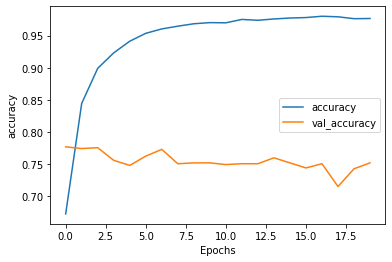

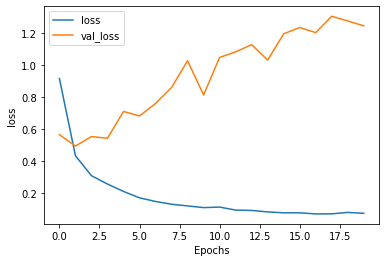

In [9]:
# Graphing the model history.

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")